In [11]:
import sys
sys.path.append('..')
from pathlib import Path
import urllib
import gzip
import tempfile

import matplotlib.pyplot as plt
import xarray as xr
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES

from datetime import datetime
from dateutil import tz

from Map import Map

In [12]:
LOCATION = 'florida'

In [13]:
def xr_read_compressed_dataset(URL):
    response = urllib.request.urlopen(URL)
    compressed_file = response.read()

    with tempfile.NamedTemporaryFile(suffix='.grib2') as f:
        f.write(gzip.decompress(compressed_file))
        return xr.load_dataset(f.name)

In [14]:
ds = xr_read_compressed_dataset('https://mrms.ncep.noaa.gov/data/2D/NLDN_CG_030min_AvgDensity/'
                                'MRMS_NLDN_CG_030min_AvgDensity.latest.grib2.gz')
ds

<xarray.Dataset>
Dimensions:         (latitude: 3500, longitude: 7000)
Coordinates:
    time            datetime64[ns] 2023-04-29T20:31:00
    step            timedelta64[ns] 00:00:00
    heightAboveSea  float64 0.0
  * latitude        (latitude) float64 54.99 54.98 54.98 ... 20.03 20.02 20.01
  * longitude       (longitude) float64 230.0 230.0 230.0 ... 300.0 300.0 300.0
    valid_time      datetime64[ns] 2023-04-29T20:31:00
Data variables:
    unknown         (latitude, longitude) float32 -1.0 -1.0 -1.0 ... -1.0 -1.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2023-04-29T15:33 GRIB to CDM+CF via cfgrib-0.9.1...

In [15]:
BOTTOM_LAT = 23
TOP_LAT = 40
LEFT_LON = -110
RIGHT_LON = -70

LAT_SLICE = slice(TOP_LAT, BOTTOM_LAT)
LON_SLICE = slice(360 + LEFT_LON, 360 + RIGHT_LON)

In [16]:
d = ds.sel(latitude=LAT_SLICE, longitude=LON_SLICE)
mrms_values = d.unknown

def convert_datetime(mrms_time):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/Chicago')
    utc_time = datetime.strptime(mrms_time, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

VALID_TIME = convert_datetime(str(d.time.values).split('.')[0])

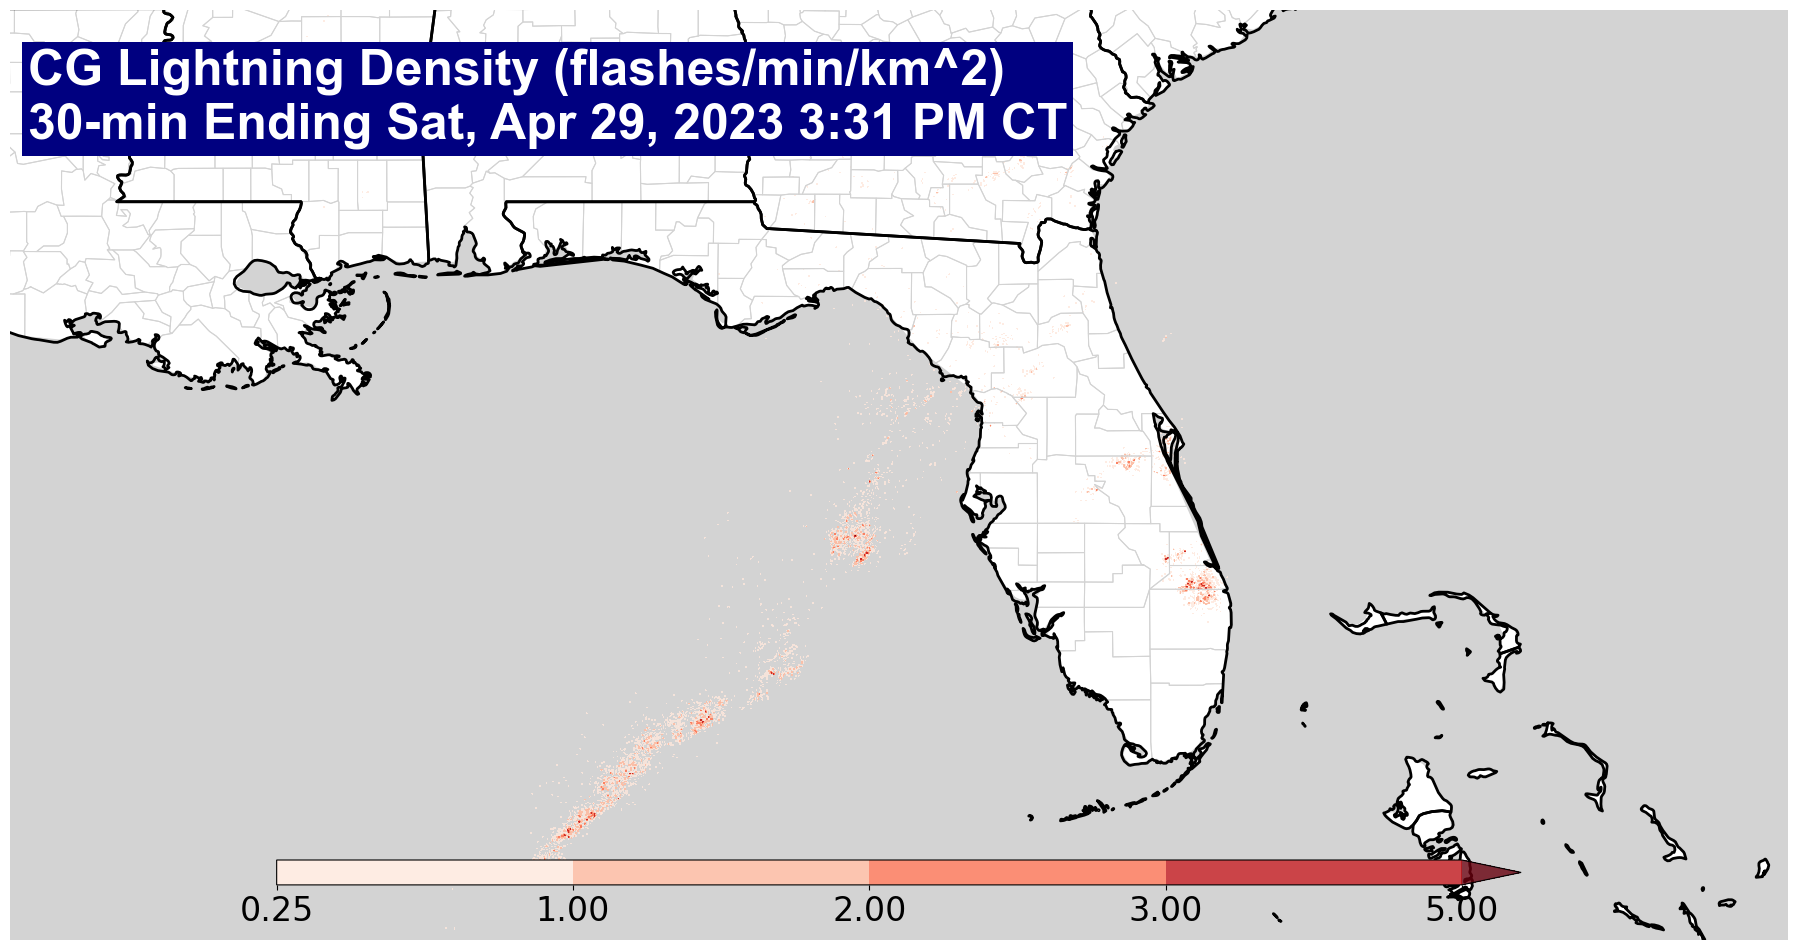

In [17]:
new_map = Map(LOCATION)
new_map.add_counties()
new_map.add_title(f'CG Lightning Density (flashes/min/km^2)\n30-min Ending {VALID_TIME} CT')

fig, ax = new_map.make_map()

contour = ax.contourf(d.longitude, d.latitude, mrms_values, 
                      [0.25, 1.00, 2.00, 3.00, 5.00], 
                      cmap=plt.cm.Reds, transform=ccrs.PlateCarree(),
                      alpha=0.8, extend='max')

cbar = plt.colorbar(contour, orientation='horizontal', pad=-0.08, aspect=50, shrink=0.7)
cbar.ax.tick_params(labelsize='24')


# Save and show figure
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'mrms'
plt.savefig(f'{graphics_dir}/lightning-density.png', dpi=72)
plt.show()